# CNN GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#  to read image from url
from imageio import imread
# to display image
from PIL import Image
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import torchvision
import torchvision.transforms as T # provides all the transformations of images
from torch.utils.data import DataLoader, Dataset,Subset
from sklearn.model_selection import train_test_split

In [2]:
transform = T.Compose(
    [
    T.ToTensor(),
    T.Resize(64),
    T.Normalize(.5,.5)
]
)
dataset = torchvision.datasets.FashionMNIST(root='../data',download=False,transform=transform)

In [3]:
classes2Keep = ['Trouser','Sneaker','Pullover']
images2use = torch.Tensor()
for i in range(len(classes2Keep)):
    classIdx = dataset.classes.index(classes2Keep[i])
    images2use = torch.cat((images2use,torch.where(dataset.targets==classIdx)[0]),0).type(torch.LongTensor)

batchSize = 100
sampler = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset,batch_size=batchSize,sampler=sampler,drop_last=True)

In [4]:
len(data_loader)

180

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,4,2,1,bias=False)
        self.conv2 = nn.Conv2d(64,128,4,2,1,bias=False)
        self.conv3 = nn.Conv2d(128,256,4,2,1,bias=False)
        self.conv4 = nn.Conv2d(256,512,4,2,1,bias=False)
        self.conv5 = nn.Conv2d(512,1,4,1,0,bias=False)

        # batch norm
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)

    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.bn1(self.conv2(x)),0.2)
        x = F.leaky_relu(self.bn2(self.conv3(x)),0.2)
        x = F.leaky_relu(self.bn3(self.conv4(x)),0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1, 1)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100,512,4,1,0,bias=False)
        self.deconv2 = nn.ConvTranspose2d(512,256,4,2,1,bias=False)
        self.deconv3 = nn.ConvTranspose2d(256,128,4,2,1,bias=False)
        self.deconv4 = nn.ConvTranspose2d(128,64,4,2,1,bias=False)
        self.deconv5 = nn.ConvTranspose2d(64,1,4,2,1,bias=False)

        # batch norm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self,x):
        x = F.leaky_relu(self.bn1(self.deconv1(x)),0.2)
        x = F.leaky_relu(self.bn2(self.deconv2(x)),0.2)
        x = F.leaky_relu(self.bn3(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.deconv4(x)), 0.2)
        x = torch.tanh(self.deconv5(x))
        return x

In [22]:
def trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, num_epochs, loader, device):
    num_epochs = int(num_epochs / len(loader))
    losses = np.zeros((num_epochs, 2))
    descDecision = np.zeros((num_epochs, 2))

    for epoch in range(num_epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        d_acc_real = 0
        d_acc_fake = 0
        num_batches = 0

        for real_data, _ in loader:
            batch_size = real_data.size(0)
            real_data = real_data.to(device)

            # Generate fake data
            noise = torch.randn(batch_size, 100,1,1).to(device)
            fake_data = gnet(noise)

            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ----- Train Discriminator -----
            pred_real = dnet(real_data)
            pred_fake = dnet(fake_data)

            d_loss_real = lossFun(pred_real, real_labels)
            d_loss_fake = lossFun(pred_fake, fake_labels)
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Discriminator accuracy on real and fake
            d_acc_real += torch.mean((pred_real > 0.5).float()).item()
            d_acc_fake += torch.mean((pred_fake < 0.5).float()).item()
            epoch_d_loss += d_loss.item()

            # ----- Train Generator -----
            noise =  torch.randn(batch_size, 100,1,1).to(device)
            fake_data = gnet(noise)
            pred_fake = dnet(fake_data)

            g_loss = lossFun(pred_fake, real_labels)  # Want discriminator to think fakes are real

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            num_batches += 1

        # Store average loss and discriminator accuracy for this epoch
        losses[epoch, 0] = epoch_d_loss / num_batches
        losses[epoch, 1] = epoch_g_loss / num_batches
        descDecision[epoch, 0] = d_acc_real / num_batches
        descDecision[epoch, 1] = d_acc_fake / num_batches

        print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {losses[epoch, 0]:.4f} | G Loss: {losses[epoch, 1]:.4f} | D Acc Real: {descDecision[epoch, 0]:.2f} | D Acc Fake: {descDecision[epoch, 1]:.2f}")

    return losses, descDecision

In [23]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [24]:
lossFun = nn.BCELoss()

dnet = Discriminator().to(device)
gnet = Generator().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0002,betas=(0.5,0.999))

In [25]:
losses, descDecision = trainGan(dnet, gnet, lossFun, d_optimizer, g_optimizer, 2500, data_loader,device)

Epoch 1/13 | D Loss: 0.2604 | G Loss: 6.6970 | D Acc Real: 0.97 | D Acc Fake: 0.97
Epoch 2/13 | D Loss: 0.7393 | G Loss: 2.3882 | D Acc Real: 0.85 | D Acc Fake: 0.87
Epoch 3/13 | D Loss: 0.7658 | G Loss: 2.4127 | D Acc Real: 0.84 | D Acc Fake: 0.85
Epoch 4/13 | D Loss: 0.6811 | G Loss: 2.5575 | D Acc Real: 0.85 | D Acc Fake: 0.86
Epoch 5/13 | D Loss: 0.6757 | G Loss: 2.7108 | D Acc Real: 0.86 | D Acc Fake: 0.86
Epoch 6/13 | D Loss: 0.6782 | G Loss: 2.6277 | D Acc Real: 0.85 | D Acc Fake: 0.86
Epoch 7/13 | D Loss: 0.6478 | G Loss: 2.6288 | D Acc Real: 0.86 | D Acc Fake: 0.87
Epoch 8/13 | D Loss: 0.6387 | G Loss: 2.7718 | D Acc Real: 0.86 | D Acc Fake: 0.87
Epoch 9/13 | D Loss: 0.5445 | G Loss: 2.9305 | D Acc Real: 0.89 | D Acc Fake: 0.89
Epoch 10/13 | D Loss: 0.4384 | G Loss: 3.2466 | D Acc Real: 0.92 | D Acc Fake: 0.93
Epoch 11/13 | D Loss: 0.3787 | G Loss: 3.5864 | D Acc Real: 0.93 | D Acc Fake: 0.94
Epoch 12/13 | D Loss: 0.4758 | G Loss: 3.3732 | D Acc Real: 0.91 | D Acc Fake: 0.91
E

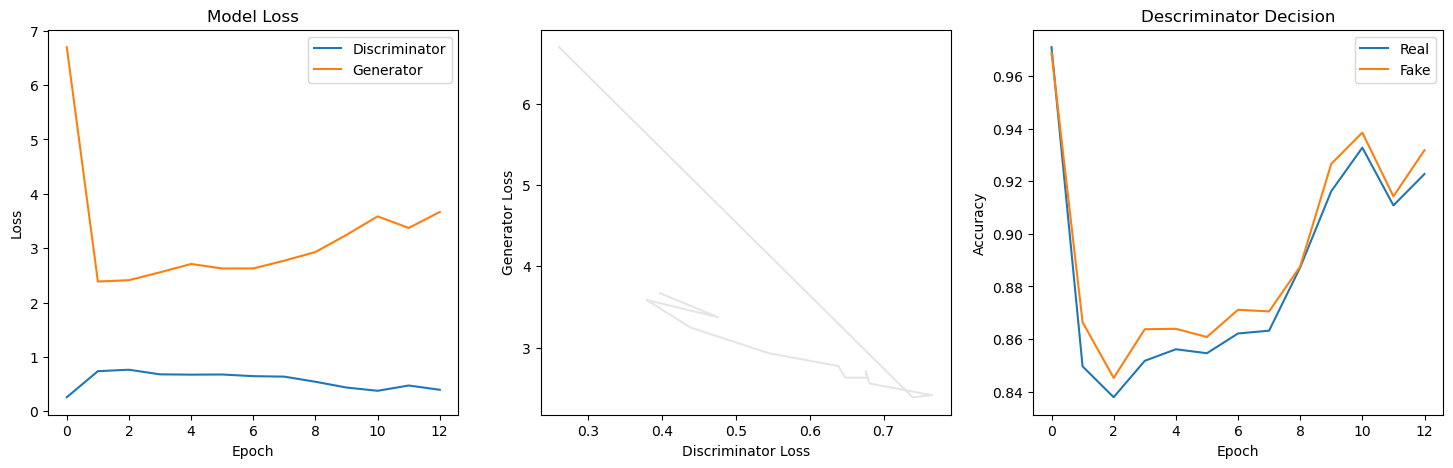

In [32]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discriminator', 'Generator'])

ax[1].plot(losses[:,0],losses[:,1],'k',alpha=.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(descDecision)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Descriminator Decision')
ax[2].legend(['Real', 'Fake'])

plt.show()


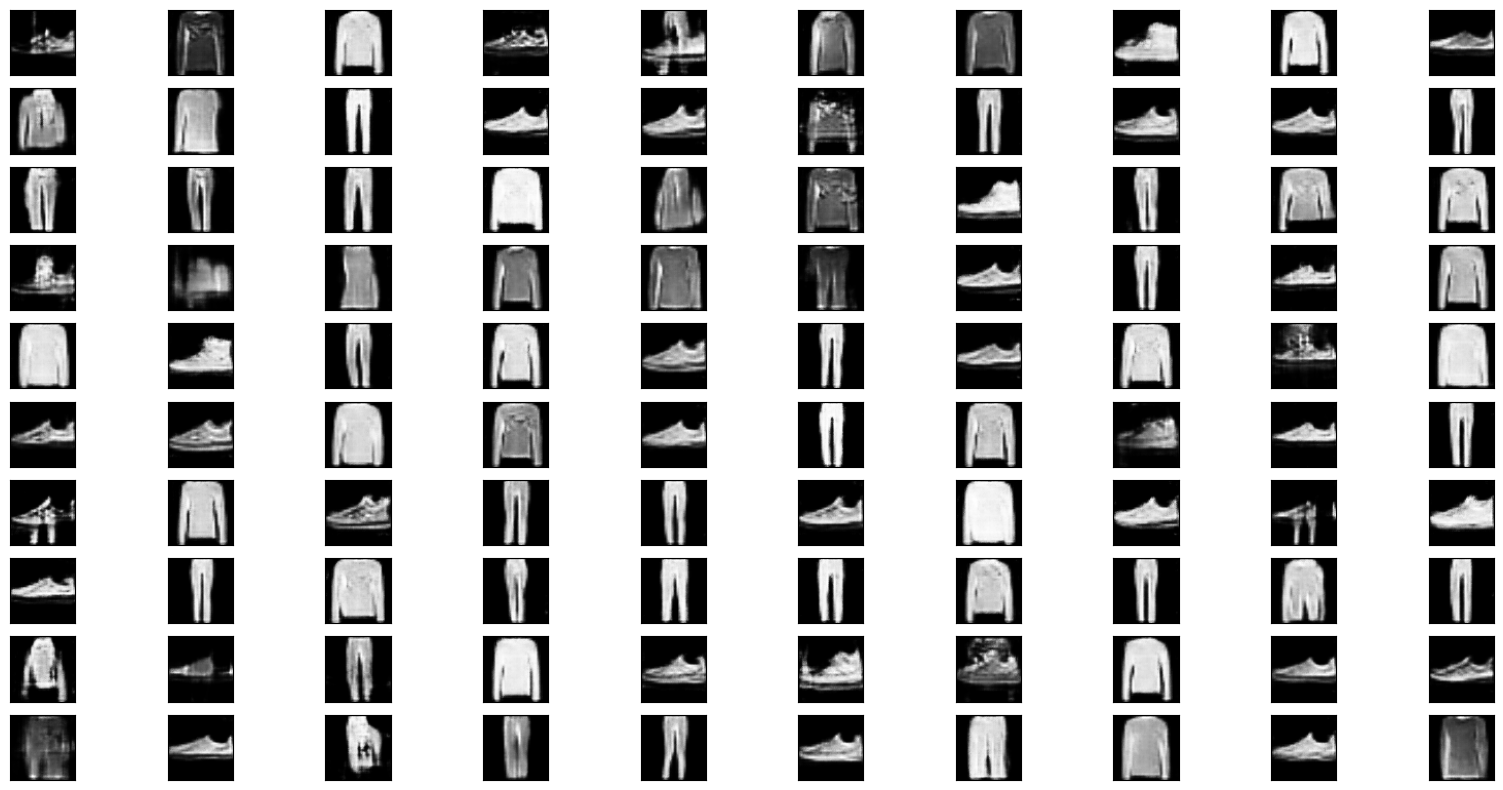

In [31]:
gnet.eval()
fake_data = gnet(torch.randn(100, 100,1,1).to(device)).cpu()
fig,axs = plt.subplots(10, 10,figsize=(20,10))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i, :,].detach().squeeze(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
 
plt.show()